In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
from data import load_finches_2012, load_finches_1975
from utils import ECDF

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df12 = load_finches_2012()
df12['shape'] = df12['beak_depth'] / df12['beak_length']

df12 = df12[df12['species'] != 'unknown']
df75 = load_finches_1975()

df = df12  # convenient alias

In [3]:
df12.head(5)

,band,species,beak_length,beak_depth,species_enc,shape
0,19022,fortis,10.0,8.5,0,0.850000
1,19028,fortis,12.5,8.9,0,0.712000
2,19032,fortis,9.3,7.5,0,0.806452
3,19041,fortis,10.3,9.6,0,0.932039
4,19044,fortis,11.0,9.2,0,0.836364


In [4]:
fortis_idx = df[df['species'] == 'fortis'].index
scandens_idx = df[df['species'] == 'scandens'].index

In [30]:
# Mega-model incorporating shape as well. 
# We will also analyze the SD in addition to the mean.

with pm.Model() as beak_model:
    # SD can only be positive, therefore it is reasonable to constrain to >0
    # Likewise for betas.
    sd_hyper = pm.HalfCauchy('sd_hyper', beta=100, shape=(2,))
    beta_hyper = pm.HalfCauchy('beta_hyper', beta=100, shape=(2,))
    
    # Beaks cannot be of "negative" mean, therefore, HalfNormal is 
    # a reasonable, constrained prior.
    mean_depth = pm.HalfNormal('mean_depth', sd=sd_hyper[0], shape=(2,))
    sd_depth = pm.HalfCauchy('sd_depth', beta=beta_hyper[0], shape=(2,))
    
    mean_length = pm.HalfNormal('mean_length', sd=sd_hyper[1], shape=(2,))
    sd_length = pm.HalfCauchy('sd_length', beta=beta_hyper[1], shape=(2,))

    nu = pm.Exponential('nu', lam=1/29.) + 1
    
    # Define the likelihood distribution for the data.
    depth = pm.StudentT('beak_depth', 
                        nu=nu,
                        mu=mean_depth[df['species_enc']], 
                        sd=sd_depth[df['species_enc']], 
                        observed=df['beak_depth'])
    
    length = pm.StudentT('beak_length',
                         nu=nu,
                         mu=mean_length[df['species_enc']],
                         sd=sd_length[df['species_enc']],
                         observed=df['beak_length'])

In [31]:
with beak_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_log__, sd_length_log__, mean_length_log__, sd_depth_log__, mean_depth_log__, beta_hyper_log__, sd_hyper_log__]
100%|██████████| 2500/2500 [00:43<00:00, 57.26it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1cf85128>,
      dtype=object)

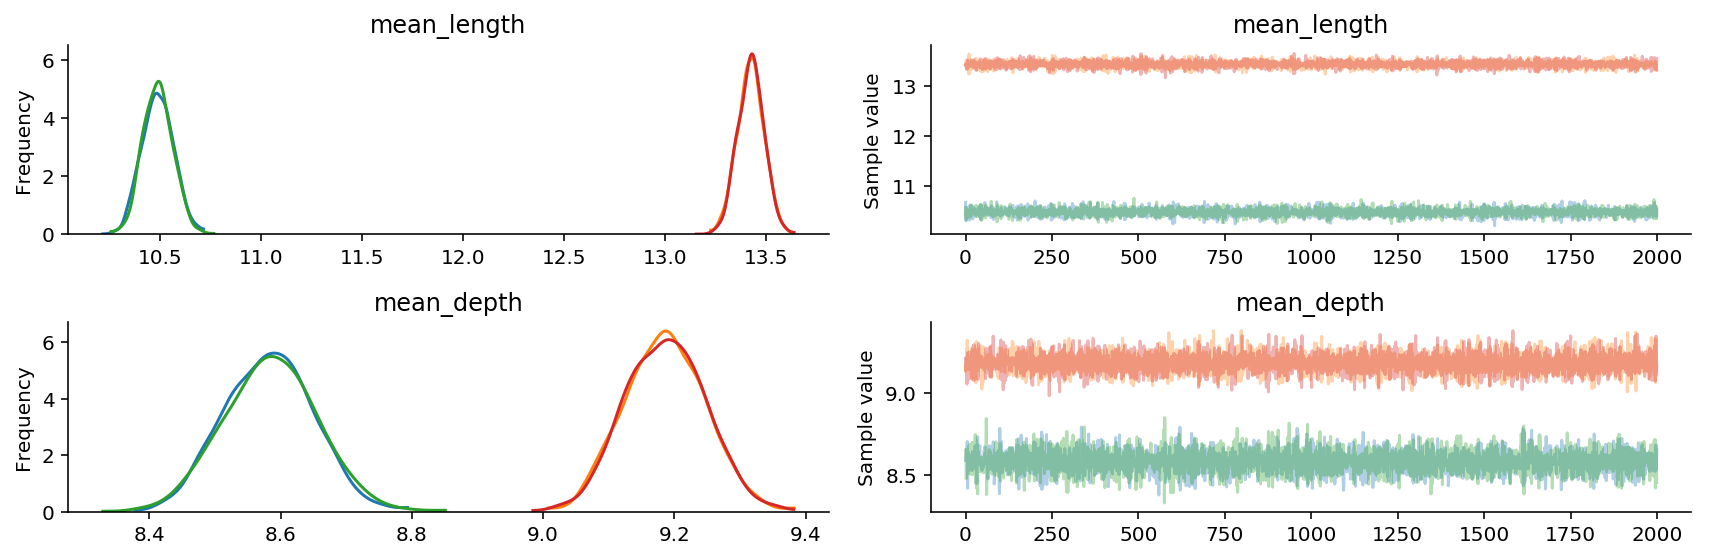

In [32]:
pm.traceplot(trace, varnames=['mean_length', 'mean_depth'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d163208>,
      dtype=object)

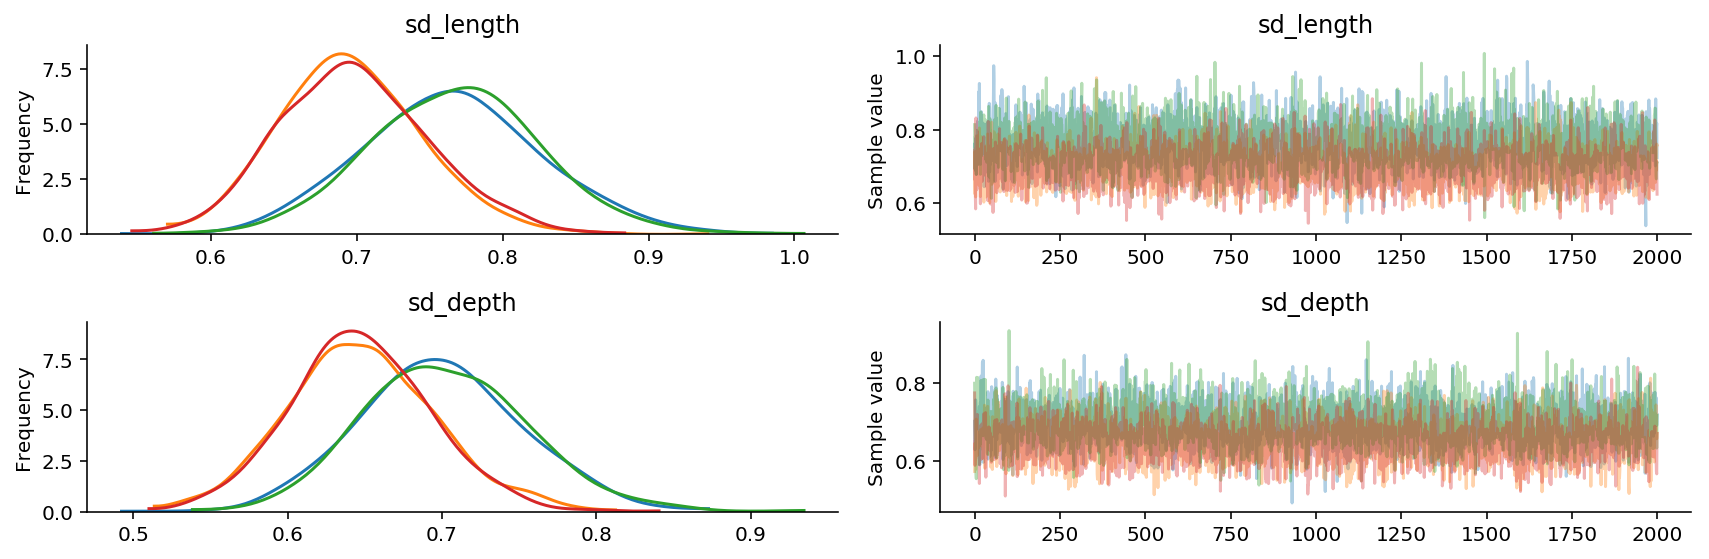

In [33]:
pm.traceplot(trace, varnames=['sd_length', 'sd_depth'])

In [34]:
samples = pm.sample_ppc(trace, model=beak_model)
samples

100%|██████████| 2000/2000 [00:03<00:00, 568.80it/s]


{'beak_depth': array([[ 8.16959079,  8.60988855,  9.22112556, ...,  9.50045448,
          8.64204484,  8.88292367],
        [ 7.54851211,  8.03436162,  7.91864548, ...,  9.58999796,
          8.69558106,  8.27523642],
        [ 8.30222648,  8.78913259,  8.22602669, ...,  9.45933864,
         10.19448463,  8.64917085],
        ...,
        [ 8.18425852,  8.65999607,  8.47572418, ...,  8.83622224,
          9.0596398 ,  9.00358671],
        [ 9.35229346,  8.71747424,  8.16534606, ...,  9.30776237,
          8.61131273,  9.49561965],
        [ 8.50311898,  8.94135771,  9.34560487, ...,  9.88485544,
          8.54778636,  9.59577793]]),
 'beak_length': array([[ 9.97979041,  9.53034638,  9.35444788, ..., 14.31846117,
         13.28492776, 13.97124523],
        [ 8.00178196, 11.28133875,  9.82976544, ..., 12.79799709,
         15.01125282, 13.50804908],
        [10.89576933,  9.33016141,  9.87344173, ..., 13.6737447 ,
         12.93373729, 12.9975309 ],
        ...,
        [10.21379111, 11.

PPC check for Fortis

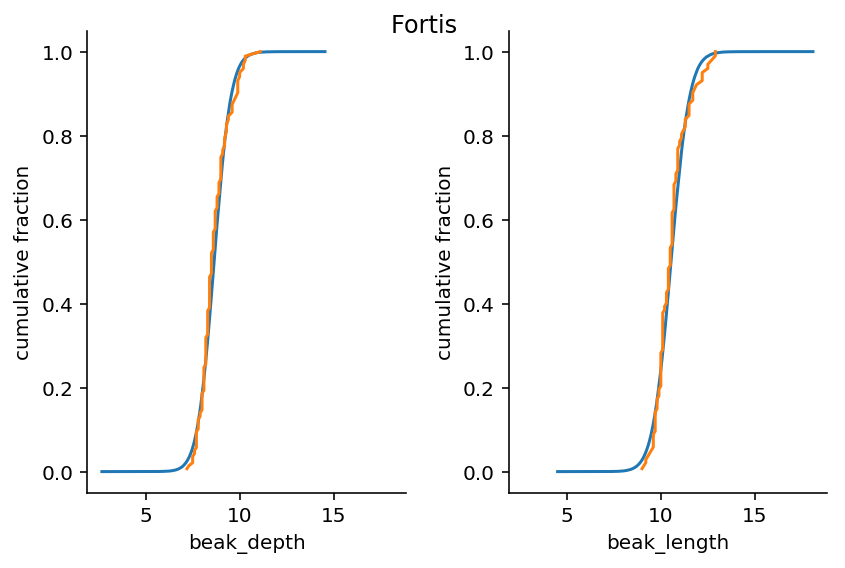

In [40]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex=ax1)

def plot_ppc_data(samples, df, idxs, column, ax):
    x, y = ECDF(samples[column][:, idxs].flatten())
    ax.plot(x, y, label='ppc')
    x, y = ECDF(df.iloc[idxs][column])
    ax.plot(x, y, label='data')
    ax.set_xlabel(column)
    ax.set_ylabel('cumulative fraction')
    return ax

ax1 = plot_ppc_data(samples, df, fortis_idx, 'beak_depth', ax1)
ax2 = plot_ppc_data(samples, df, fortis_idx, 'beak_length', ax2)

fig.suptitle('Fortis')
plt.tight_layout()

PPC check for Scandens

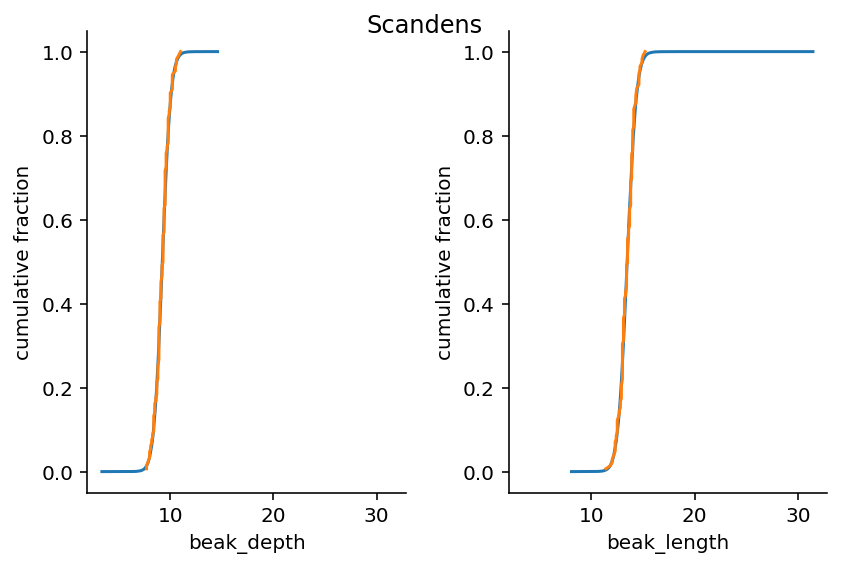

In [42]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharex=ax1)

ax1 = plot_ppc_data(samples, df, scandens_idx, 'beak_depth', ax1)
ax2 = plot_ppc_data(samples, df, scandens_idx, 'beak_length', ax2)

fig.suptitle('Scandens')
plt.tight_layout()

(array([6.30000e+01, 5.48630e+04, 2.17269e+05, 2.21905e+05, 1.89500e+03,
        3.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 4.50955101,  7.20461554,  9.89968006, 12.59474459, 15.28980912,
        17.98487365, 20.67993818, 23.37500271, 26.07006724, 28.76513176,
        31.46019629]),
 <a list of 10 Patch objects>)

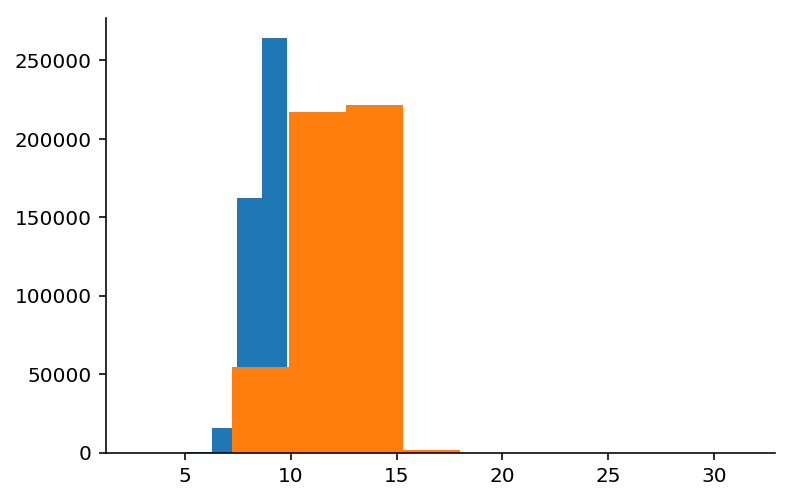

In [47]:
plt.hist(samples['beak_depth'].flatten())
plt.hist(samples['beak_length'].flatten())

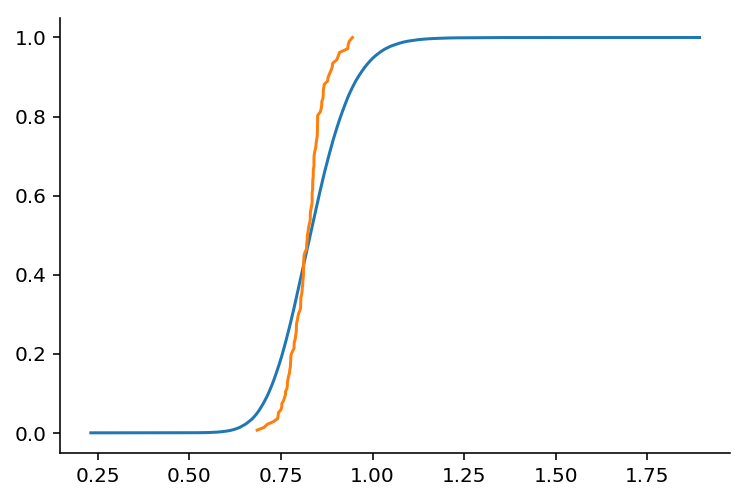

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
x, y = ECDF((samples['beak_depth'][:, fortis_idx] / samples['beak_length'][:, fortis_idx]).flatten())
ax.plot(x, y)
x, y = ECDF(df.loc[fortis_idx, 'shape'])
ax.plot(x, y)

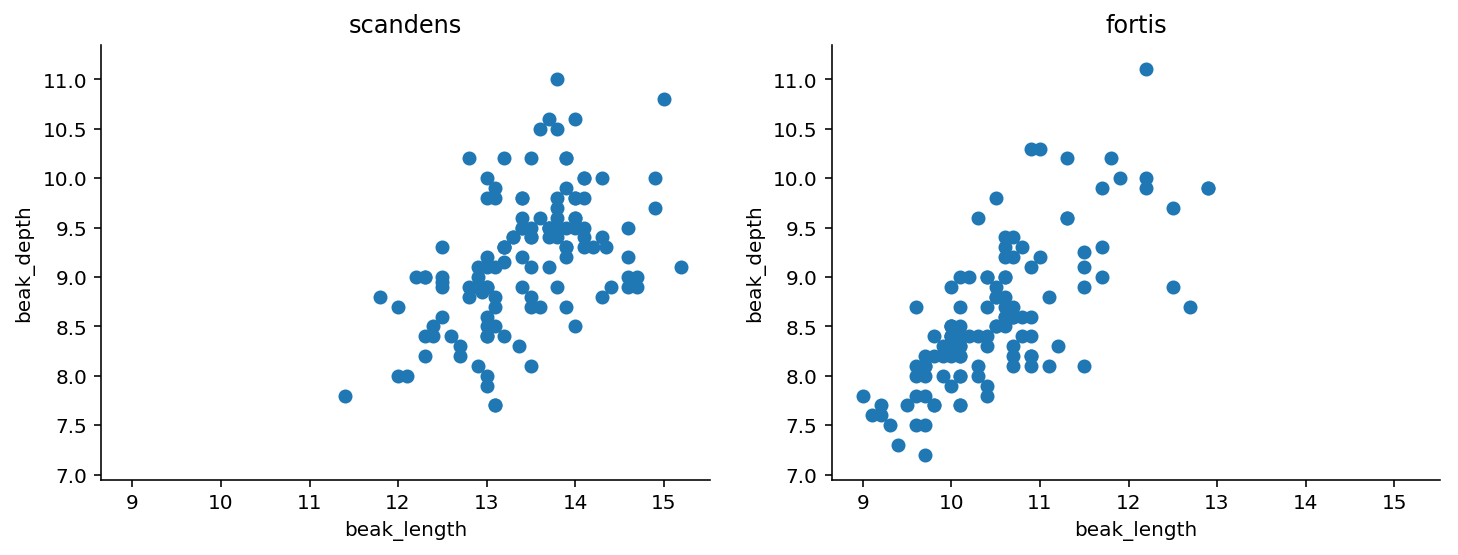

In [58]:
fig = plt.figure(figsize=(12, 4))

def plot_length_depth_scatter(df, idxs, title, ax):
    ax.scatter(df.iloc[idxs]['beak_length'], df.iloc[idxs]['beak_depth'])
    ax.set_xlabel('beak_length')
    ax.set_ylabel('beak_depth')
    ax.set_title(title)
    return ax


ax1 = fig.add_subplot(121)
ax1 = plot_length_depth_scatter(df, scandens_idx, 'scandens', ax1)

ax2 = fig.add_subplot(122, sharex=ax1, sharey=ax1)
ax2 = plot_length_depth_scatter(df, fortis_idx, 'fortis', ax2)


Going to try a new model: we explicity model depth and length jointly, as a multivariate gaussian.

In [99]:
with pm.Model() as mv_beaks:  # multivariate beak model
    packed_L = pm.LKJCholeskyCov('packed_L', n=2,
                             eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
    L = pm.expand_packed_triangular(2, packed_L)
    sigma = pm.Deterministic('sigma', L.dot(L.T))

    mu = pm.HalfNormal('mu', sd=20, shape=(2,))
    
    like = pm.MvNormal('like', mu=mu, cov=sigma, observed=df[['beak_depth', 'beak_length']].values)

In [100]:
with mv_beaks:
    trace_mv = pm.sample(2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_log__, packed_L_cholesky_cov_packed__]
100%|██████████| 2500/2500 [00:55<00:00, 45.45it/s]
The acceptance probability does not match the target. It is 0.8969353081919293, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c28e834e0>,
      dtype=object)

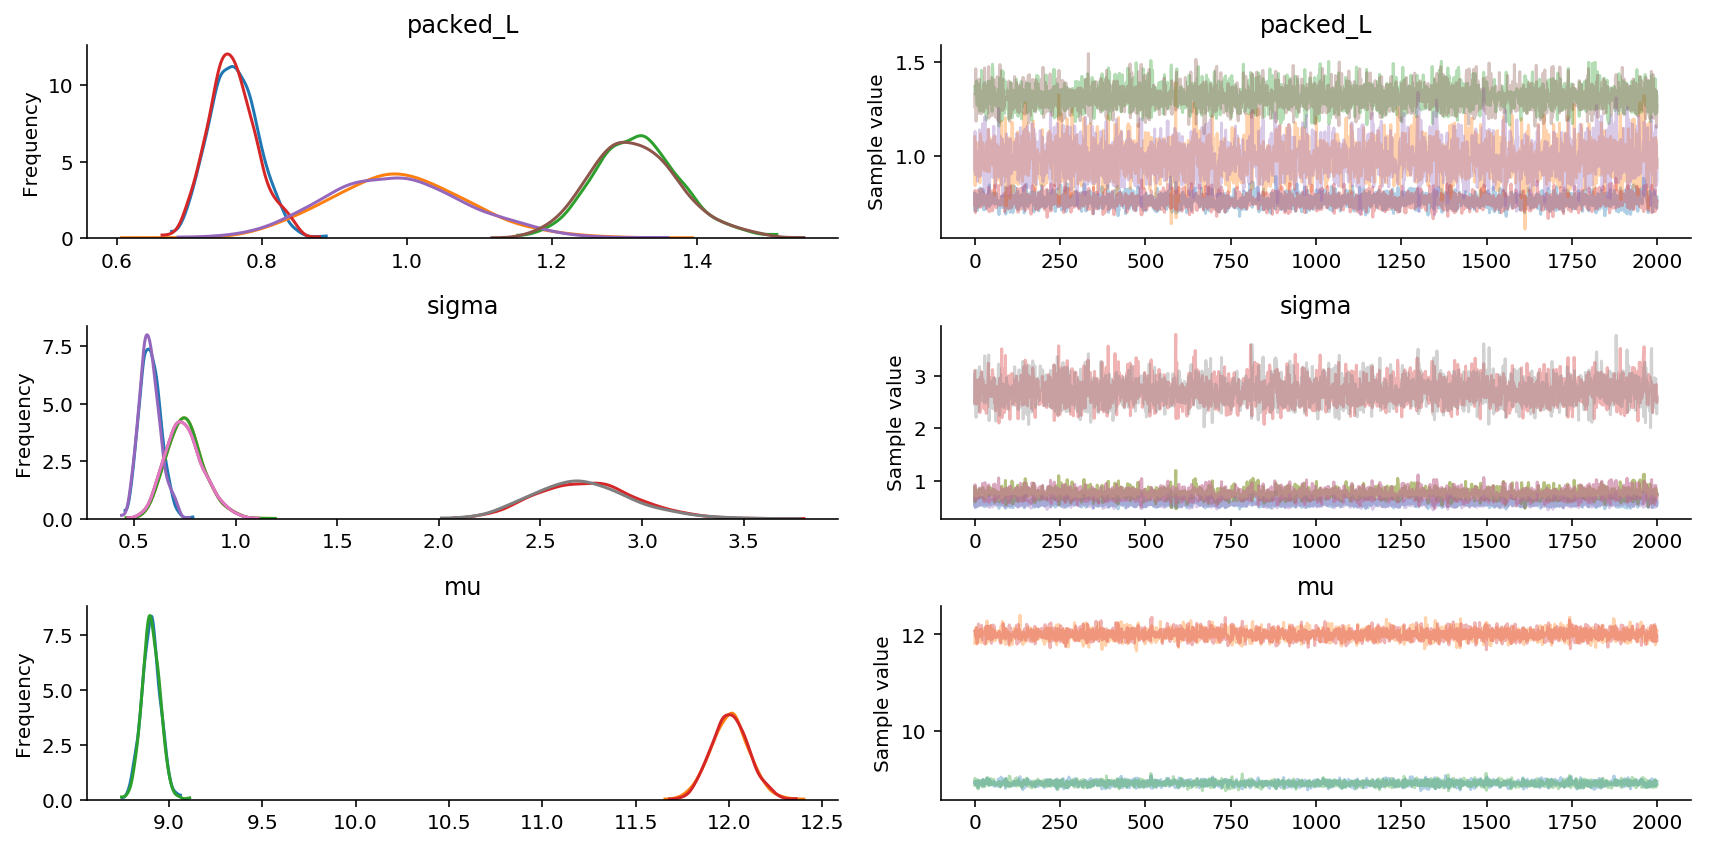

In [101]:
pm.traceplot(trace_mv)

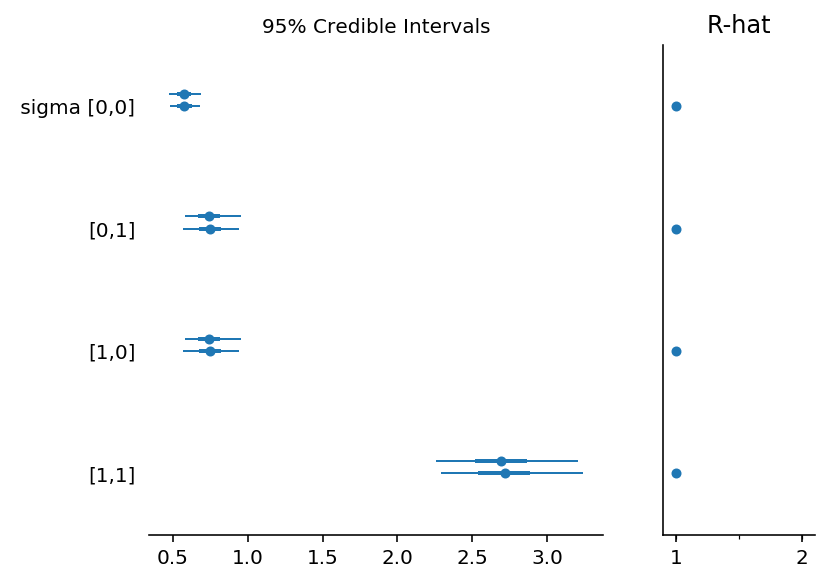

In [103]:
pm.forestplot(trace_mv, varnames=['sigma'])

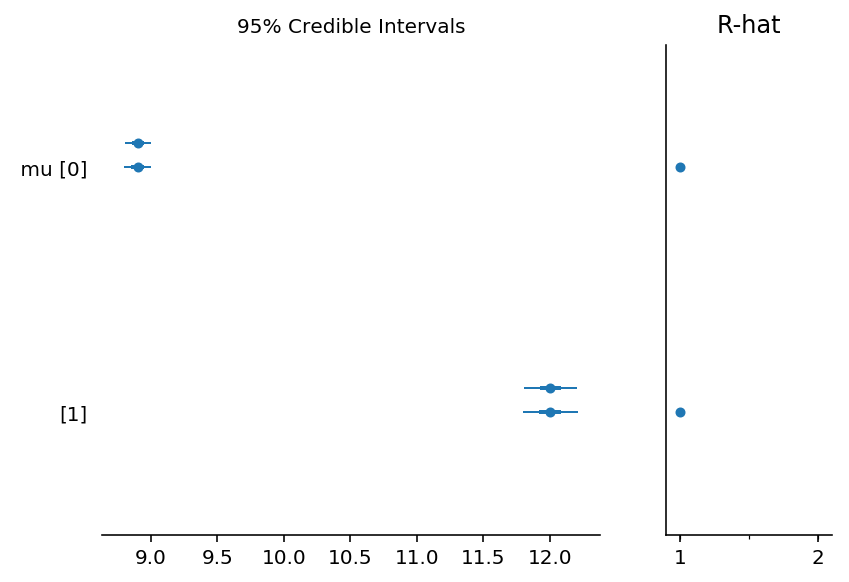

In [104]:
pm.forestplot(trace_mv, varnames=['mu'])

In [105]:
samples_mv = pm.sample_ppc(trace, model=mv_beaks)

  0%|          | 0/2000 [00:00<?, ?it/s]


MissingInputError: Input 0 of the graph (indices start from 0), used to compute AdvancedSubtensor1(packed_L_cholesky_cov_packed__, TensorConstant{[0 2]}), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.